In [713]:
# %load_ext autoreload
# %autoreload 2
from pathlib import Path

import numpy as np
import numpy.typing as npt
import xarray as xr
from scipy.interpolate import CubicSpline, griddata, make_interp_spline, PchipInterpolator
import scipy.constants as constants
import scipy.fft as fft
import scipy.signal as signal
import scipy.linalg as linalg
import matplotlib.pyplot as plt
import stereoid.oceans.tops_model as TOPS
import drama.io.cfg as cfg

import stereoid.utils.config as st_config

In [2]:
user_cfg_path = Path("~/Code/WSOA Scientific Workbench/PAR/user.cfg").expanduser()
# path to PAR file
# Set this to the directory of your data and model results
paths = st_config.parse(user_cfg_path, section="Paths")
parfile = paths["par"] / "Hrmny_XTI_finalists_timeline.cfg"
par_data = cfg.ConfigFile(parfile)

/home/andreas/Code/stereoid_public/stereoid /home/andreas/Code/WSOA Scientific Workbench/PAR/user.cfg


In [3]:
tc_path = paths["results"] / "Maria TC data.nc"
l1_path = paths["results"] / "L1data.nc"
h_std_path = paths["results"] / "h_std.nc"

In [4]:
l1_ds = xr.open_dataset(l1_path)
tc_ds = xr.open_dataset(tc_path)
l1_ds = l1_ds.rename({"gr": "grg"})
l1_ds = l1_ds.rename_vars({"incm": "inc"})
tc_ds = tc_ds.rename({"gr": "grg"})
tc_ds = tc_ds.rename_vars({"incm": "inc"})
h_std_ds = xr.open_dataset(h_std_path)

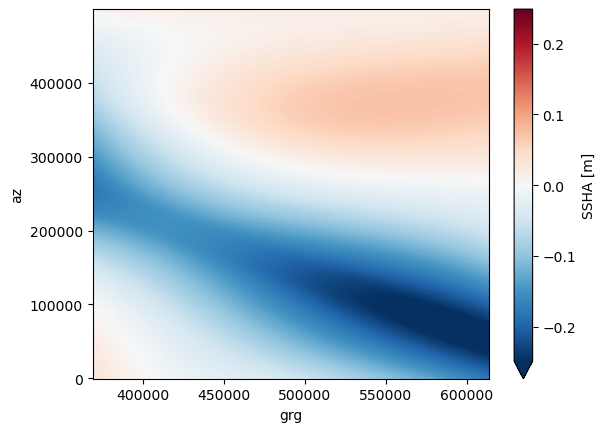

In [5]:
im = tc_ds.SSHA.plot(robust=True)
# im.axes.set_aspect("equal")

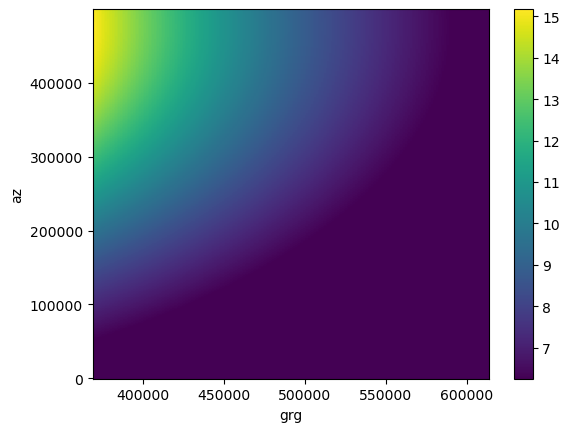

In [6]:
np.sqrt(tc_ds.U10s_x**2 + tc_ds.U10s_y**2).plot()

In [7]:
asc_lats = h_std_ds.latitude.isel(time=slice(0, 2963)).to_numpy()
inc_grid = np.zeros_like(asc_lats) + h_std_ds.incidence.to_numpy()

In [8]:
l1_lats = l1_ds.latitude
l1_inc = np.zeros_like(l1_lats) + np.rad2deg(l1_ds.inc).to_numpy()

In [9]:
irregular_grid_points = np.stack([asc_lats.ravel(), inc_grid.ravel()], -1)  # shape (N, 2) in 2d
out_grid = (l1_lats, l1_inc)

In [10]:
def interp_to_grid(u, in_grid, out_grid):
    z = griddata(in_grid, u.flatten(), out_grid, fill_value = np.nan)
    return z

In [11]:
h_std_grid = griddata(
    irregular_grid_points,
    h_std_ds.sel(formation=4, wind_sp=7.5)
    .isel(time=slice(0, 2963))
    .height_std.to_numpy()
    .flatten(),
    out_grid,
    method="cubic"
)

h_amb_grid = griddata(
    irregular_grid_points,
    h_std_ds.sel(formation=4, wind_sp=7.5)
    .isel(time=slice(0, 2963))
    .h_amb.to_numpy()
    .flatten(),
    out_grid,
    method="cubic"
)

In [12]:
h_std_roi = xr.zeros_like(tc_ds.SSHA)
h_std_roi += h_std_grid
h_amb_roi = xr.zeros_like(tc_ds.SSHA)
h_amb_roi += h_amb_grid

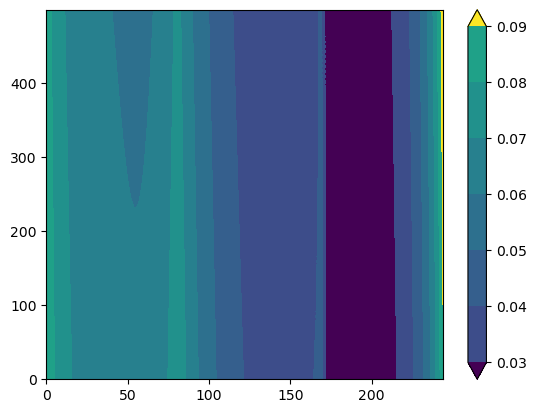

In [13]:
fig, ax = plt.subplots()
im = ax.contourf(h_std_grid, vmin=0, vmax=0.15, extend="both")
fig.colorbar(im, ax=ax)

In [14]:
latitude = tc_ds.latitude.isel(grg=0)
parameters = TOPS.tops_parameters(latitude, user_cfg_path, "Hrmny_XTI_finalists_timeline.cfg")
tops_acqs = TOPS.TOPSAcquisitions(parameters, 0)

/home/andreas/Code/stereoid_public/stereoid /home/andreas/Code/WSOA Scientific Workbench/PAR/user.cfg


In [15]:
tc_iw1 = tops_acqs.extract_subswath(tc_ds, 1)
tc_iw2 = tops_acqs.extract_subswath(tc_ds, 2, True)
tc_iw3 = tops_acqs.extract_subswath(tc_ds, 3, True)

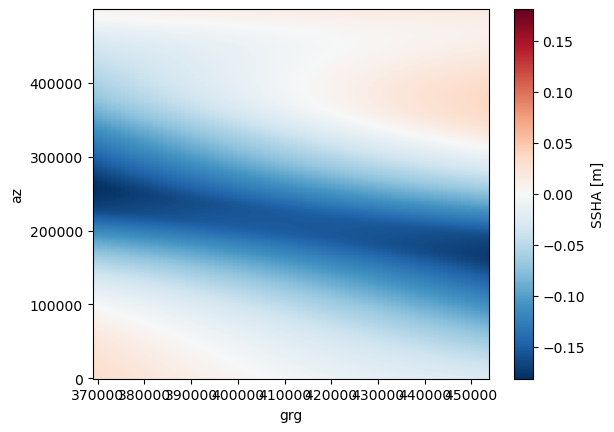

In [16]:
im = tc_iw1.SSHA.plot()

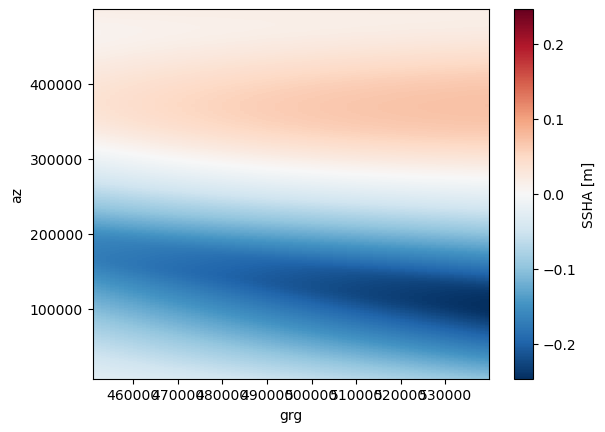

In [17]:
im = tc_iw2.SSHA.plot()

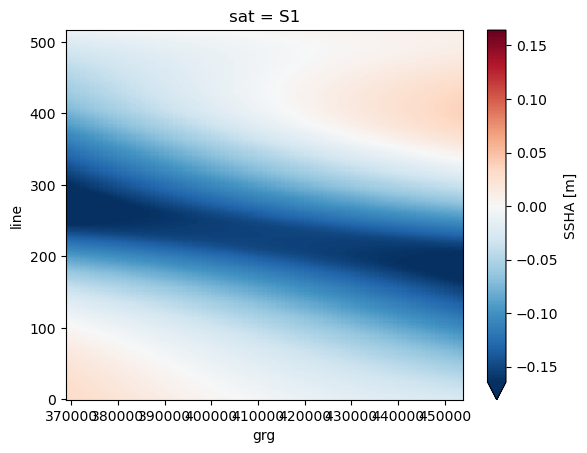

In [18]:
mosaic_iw1 = tops_acqs.mosaic(tc_iw1, 24, False, False, "SSHA")
im = mosaic_iw1.sel(sat="S1").SSHA.plot(robust=True)

In [19]:
num_samples = 70_000
fs = 1000
Ts = 1 / fs
time_phase = np.linspace(0, num_samples * Ts, num_samples, endpoint=False)

In [20]:
rng = np.random.default_rng()

In [21]:
P = np.zeros(num_samples)
n0 = int(np.floor(num_samples / 2)) + 1
shifted_freq = fft.fftshift(fft.fftfreq(num_samples, 1 / fs))
freq_mask = (shifted_freq <= 2) & (shifted_freq >= -2)
P[freq_mask] = 14 / (np.sum(freq_mask) * fs / num_samples)
phase = rng.uniform(0, 2 * np.pi, num_samples)
A = np.sqrt(num_samples * fs * P) * np.exp(1j * phase)
A[1 : n0 - 1] = np.flipud(np.conj(A[n0:]))
A[0] = np.abs(A[0])
A[n0 - 1] = P[n0 - 1]
phase_error = fft.ifft(fft.ifftshift(A))
phase_error = np.real(phase_error)

In [22]:
b1_iw1 = tops_acqs.get_burst(tc_iw1, 1, False, "SSHA")
b1_iw2 = tops_acqs.get_burst(tc_iw2, 1, False, "SSHA")

In [23]:
b1_iw1.sensing_time

<xarray.DataArray 'sensing_time' (az: 22)>
array([0.        , 0.03813675, 0.07627349, 0.11441024, 0.15254698,
       0.19068373, 0.22882048, 0.26695722, 0.30509397, 0.34323071,
       0.38136746, 0.41950421, 0.45764095, 0.4957777 , 0.53391444,
       0.57205119, 0.61018794, 0.64832468, 0.68646143, 0.72459817,
       0.76273492, 0.80087167])
Coordinates:
  * az            (az) float64 0.0 1e+03 2e+03 3e+03 ... 1.9e+04 2e+04 2.1e+04
    azimuth_time  (az) float64 0.0 0.1395 0.279 0.4186 ... 2.511 2.651 2.79 2.93

In [24]:
spl = CubicSpline(latitude, parameters.r_s)
r_sl_b1 = spl(b1_iw1.latitude.isel(grg=0))

In [25]:
Ka = (
    2
    * parameters.mean_ground_rectilinear_v() ** 2
    * par_data.sar.f0
    / (constants.c * r_sl_b1)
)

In [26]:
look_centre_time_iw1 = par_data.IWS.proc_bw[0] * 0.25 / Ka
mean_look_centre_time_iw1 = np.mean(look_centre_time_iw1)

look_centre_time_iw2 = par_data.IWS.proc_bw[1] * 0.25 / Ka
mean_look_centre_time_iw2 = np.mean(look_centre_time_iw2)

look_centre_time_iw3 = par_data.IWS.proc_bw[2] * 0.25 / Ka
mean_look_centre_time_iw3 = np.mean(look_centre_time_iw3)
sample_look_offset = int(np.ceil(mean_look_centre_time_iw1 / Ts))

In [27]:
def get_subswath_timeline(subswath, tops_acqs, n_bursts, offset):
    sensing_times = []
    for i in range(n_bursts):
        sensing_time = tops_acqs.get_burst(subswath, i+1, False, "SSHA").sensing_time.to_numpy()
        sensing_time += offset
        sensing_times.append(sensing_time)
    return sensing_times

In [28]:
sensing_times_iw1 = get_subswath_timeline(tc_iw1, tops_acqs, 24, sample_look_offset * Ts)
sensing_times_iw2 = get_subswath_timeline(tc_iw2, tops_acqs, 24, sample_look_offset * Ts)
sensing_times_iw3 = get_subswath_timeline(tc_iw3, tops_acqs, 24, sample_look_offset * Ts)

In [29]:
def sinc_interpolation(x: npt.NDArray, s: npt.NDArray, u: npt.NDArray) -> npt.NDArray:
    """Whittaker–Shannon interpolation.
    Args:
        x (NDArray): signal to be interpolated, can be 1D or 2D
        s (NDArray): time points of x (*s* for *samples*) 
        u (NDArray): time points of y (*u* for *upsampled*)
    Returns:
        NDArray: interpolated signal at time points *u*
    """
    sinc_kernel = np.sinc((u - s[:, np.newaxis])/(s[1]-s[0]))

    return np.dot(x, sinc_kernel)

In [30]:
def interpolate_phase_signal_subswath(phase_signal, phase_time, sensing_times):
    phase_signals = []
    for time in sensing_times:
        phase_error_in_burst = sinc_interpolation(phase_signal, phase_time, time)
        phase_signals.append(phase_error_in_burst)
    return phase_signals

In [31]:
phase_error_iw1 = interpolate_phase_signal_subswath(phase_error, time_phase, sensing_times_iw1)
phase_error_iw2 = interpolate_phase_signal_subswath(phase_error, time_phase, sensing_times_iw2)
phase_error_iw3 = interpolate_phase_signal_subswath(phase_error, time_phase, sensing_times_iw3)

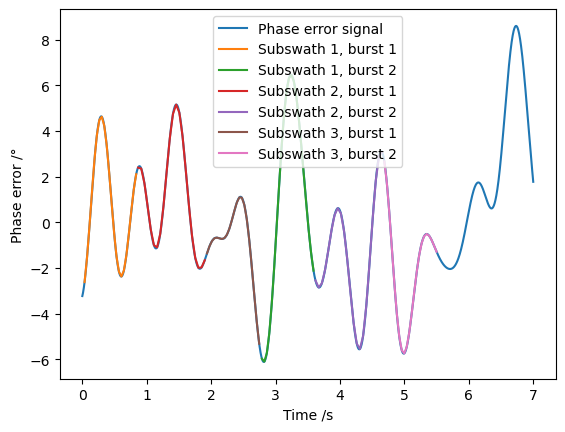

In [32]:
fig, ax = plt.subplots()
ax.plot(time_phase[0:7000], phase_error[0:7000], label="Phase error signal")
ax.plot(sensing_times_iw1[0], phase_error_iw1[0], label="Subswath 1, burst 1")
ax.plot(sensing_times_iw1[1], phase_error_iw1[1], label="Subswath 1, burst 2")
ax.plot(sensing_times_iw2[0], phase_error_iw2[0], label="Subswath 2, burst 1")
ax.plot(sensing_times_iw2[1], phase_error_iw2[1], label="Subswath 2, burst 2")
ax.plot(sensing_times_iw3[0], phase_error_iw3[0], label="Subswath 3, burst 1")
ax.plot(sensing_times_iw3[1], phase_error_iw3[1], label="Subswath 3, burst 2")
ax.set_xlabel("Time /s")
ax.set_ylabel("Phase error /°")
ax.legend()

In [33]:
mosaic_iw1 = tops_acqs.mosaic(tc_iw1, 24, False, False, "SSHA")
mosaic_iw2 = tops_acqs.mosaic(tc_iw2, 24, False, False, "SSHA")
mosaic_iw3 = tops_acqs.mosaic(tc_iw3, 24, False, False, "SSHA")

In [34]:
phase_error_tiled = []
for (iw1, iw2, iw3) in zip(phase_error_iw1, phase_error_iw2, phase_error_iw3):
    phase_error_tiled.append(iw1)
    phase_error_tiled.append(iw2)
    phase_error_tiled.append(iw3)
phase_error_tiled = np.concatenate(phase_error_tiled)

In [35]:
phase_error_iw1 = np.concatenate(phase_error_iw1)
phase_error_iw2 = np.concatenate(phase_error_iw2)
phase_error_iw3 = np.concatenate(phase_error_iw3)

In [36]:
height_error_clock_iw1 = np.deg2rad(phase_error_iw1[:, np.newaxis]) / (2 * np.pi) * h_amb_roi.sel(grg=mosaic_iw1.grg, az=mosaic_iw1.az)
mosaic_iw1_error = mosaic_iw1.SSHA + height_error_clock_iw1

height_error_clock_iw2 = np.deg2rad(phase_error_iw2[:, np.newaxis]) / (2 * np.pi) * h_amb_roi.sel(grg=mosaic_iw2.grg, az=mosaic_iw2.az)
mosaic_iw2_error = mosaic_iw2.SSHA + height_error_clock_iw2

height_error_clock_iw3 = np.deg2rad(phase_error_iw3[:, np.newaxis]) / (2 * np.pi) * h_amb_roi.sel(grg=mosaic_iw3.grg, az=mosaic_iw3.az)
mosaic_iw3_error = mosaic_iw3.SSHA + height_error_clock_iw3

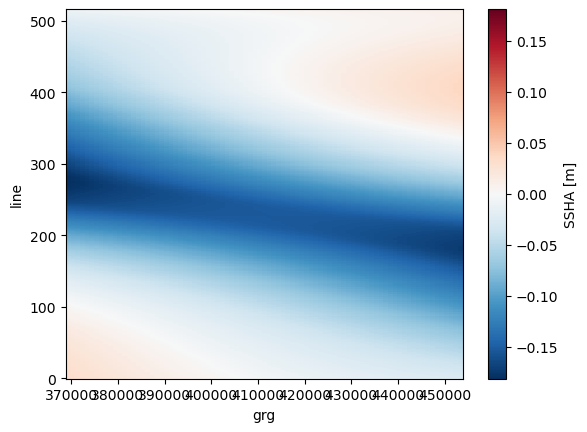

In [37]:
mosaic_iw1.SSHA.plot()

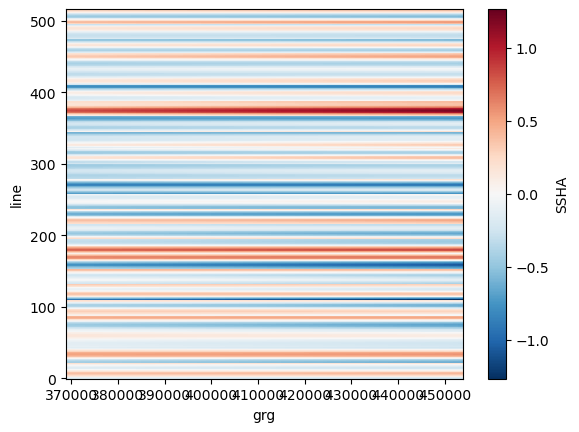

In [38]:
mosaic_iw1_error.plot()

In [39]:
sensing_times_iw1_l1 = [t - mean_look_centre_time_iw1 for t in sensing_times_iw1]
sensing_times_iw1_l2 = [t + mean_look_centre_time_iw1 for t in sensing_times_iw1]

sensing_times_iw2_l1 = [t - mean_look_centre_time_iw2 for t in sensing_times_iw2]
sensing_times_iw2_l2 = [t + mean_look_centre_time_iw2 for t in sensing_times_iw2]


sensing_times_iw3_l1 = [t - mean_look_centre_time_iw3 for t in sensing_times_iw3]
sensing_times_iw3_l2 = [t + mean_look_centre_time_iw3 for t in sensing_times_iw3]

In [40]:
phase_error_iw1_l1 = interpolate_phase_signal_subswath(phase_error, time_phase, sensing_times_iw1_l1)
phase_error_iw1_l2 = interpolate_phase_signal_subswath(phase_error, time_phase, sensing_times_iw1_l2)

In [41]:
phase_error_iw2_l1 = interpolate_phase_signal_subswath(phase_error, time_phase, sensing_times_iw2_l1)
phase_error_iw2_l2 = interpolate_phase_signal_subswath(phase_error, time_phase, sensing_times_iw2_l2)

In [42]:
phase_error_iw3_l1 = interpolate_phase_signal_subswath(phase_error, time_phase, sensing_times_iw3_l1)
phase_error_iw3_l2 = interpolate_phase_signal_subswath(phase_error, time_phase, sensing_times_iw3_l2)

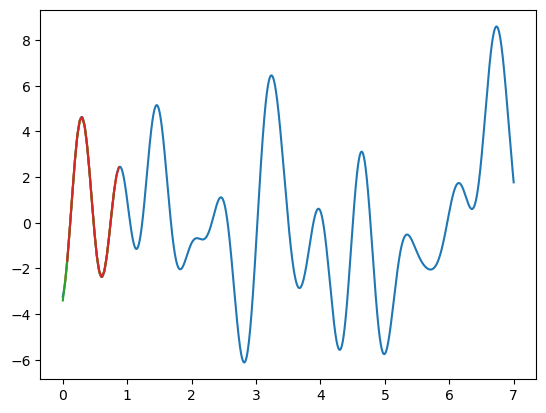

In [43]:
fig, ax = plt.subplots()
ax.plot(time_phase[0:7000], phase_error[0:7000], label="Phase error signal")
ax.plot(sensing_times_iw1[0], phase_error_iw1[:len(sensing_times_iw1[0])], label="Subswath 1, burst 1")
ax.plot(sensing_times_iw1_l1[0], phase_error_iw1_l1[0], label="Subswath 1, burst 2")
ax.plot(sensing_times_iw1_l2[0], phase_error_iw1_l2[0], label="Subswath 1, burst 2")

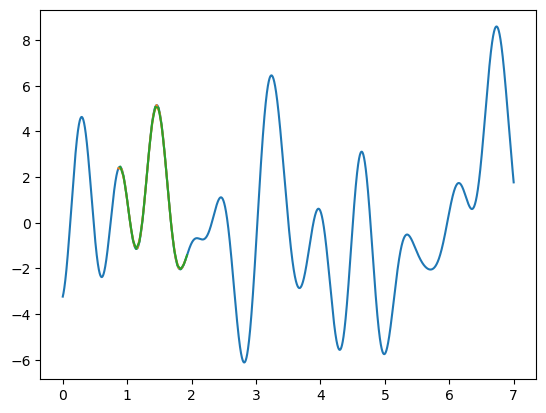

In [44]:
fig, ax = plt.subplots()
ax.plot(time_phase[0:7000], phase_error[0:7000], label="Phase error signal")
ax.plot(sensing_times_iw2[0], phase_error_iw2[:len(sensing_times_iw1[0])], label="Subswath 1, burst 1")
#ax.plot(sensing_times_iw2_l1[0], phase_error_iw2_l1[0], label="Subswath 1, burst 2")
ax.plot(sensing_times_iw2_l2[0], phase_error_iw2_l2[0], label="Subswath 1, burst 2")

In [45]:
dt_iw1 = sensing_times_iw1_l2[0][0] - sensing_times_iw1_l1[0][0]
dt_iw2 = sensing_times_iw2_l2[0][0] - sensing_times_iw2_l1[0][0]
dt_iw3 = sensing_times_iw3_l2[0][0] - sensing_times_iw3_l1[0][0]

In [46]:
phase_error_der = []
sensing_times_tiled = []
dts = []
for i in range(len(phase_error_iw1_l1)):
    der_iw1 = (phase_error_iw1_l2[i] - phase_error_iw1_l1[i]) / dt_iw1
    der_iw2 = (phase_error_iw2_l2[i] - phase_error_iw2_l1[i]) / dt_iw2
    der_iw3 = (phase_error_iw3_l2[i] - phase_error_iw3_l1[i]) / dt_iw3
    dt_1 = np.full_like(der_iw1, dt_iw1)
    dt_2 = np.full_like(der_iw2, dt_iw2)
    dt_3 = np.full_like(der_iw3, dt_iw3)
    for der in (der_iw1, der_iw2, der_iw3):
        phase_error_der.append(der)
    for t in (sensing_times_iw1[i], sensing_times_iw2[i], sensing_times_iw3[i]):
        sensing_times_tiled.append(t)
    for dt_i in (dt_1, dt_2, dt_3):
        dts.append(dt_i)

In [47]:
phase_error_der = np.concatenate(phase_error_der)
sensing_times_tiled = np.concatenate(sensing_times_tiled)
dts = np.concatenate(dts)

It is important to note that due to the subswath switching and the coarse sampling (1 km in azimuth) the sensing time sampling is not regular while the $dt$ of the derivative is regular for each subswath. Thus, the difference kernel of the estimator needs to be ammended to account for this irregular sampling of the phase error signal.

In [48]:
sensing_times_tiled[:-1][np.diff(sensing_times_tiled) > 0.06]

array([20.0678127 , 21.12692861, 21.97735919, 22.82068095, 23.88063635,
       24.73026242, 25.5735492 , 26.63434409, 27.48316566, 28.32641746,
       29.38805183, 30.23606889, 31.07928571, 32.14175958, 32.98897212,
       33.83215396, 34.89546732, 35.74187535, 36.58502222, 37.64917506,
       55.81696325, 56.87583054, 57.72649938, 58.5698315 , 59.62953828,
       60.47940262, 61.32269975, 62.38324602, 63.23230585, 64.07556801,
       65.13695377])

In [49]:
num_rows = len(phase_error_der)-1
num_cols = len(phase_error_der)
delta = np.zeros((num_rows, num_cols))
difference_kernel = np.array([-1, 1])
for i in range(num_rows):
    delta[i, i:i+2] = difference_kernel
delta = delta / np.diff(sensing_times_tiled)[:, np.newaxis] # dts
delta_sq = delta.T @ delta

In [50]:
# dt_est = np.zeros(len(phase_error_der)-2)
# for i in range(len(phase_error_der)-2):
#     dt_est[i] = sensing_times_tiled[i+2] - sensing_times_tiled[i]

In [51]:
# num_rows = len(phase_error_der)-2
# num_cols = len(phase_error_der)
# delta = np.zeros((num_rows, num_cols))
# difference_kernel = np.array([-1, 0, 1])
# for i in range(num_rows):
#     delta[i, i:i+3] = difference_kernel
# delta = delta / dt_est[:, np.newaxis] # dts
# delta_sq = delta.T @ delta

In [52]:
beta = 10000
I = np.identity(len(phase_error_der))
A = (I + beta * delta_sq)

In [53]:
x_est = linalg.solve(A, beta * delta.T @ phase_error_der[:-1])

In [54]:
np.mean((phase_error_tiled - x_est)**2)

0.5909077457884254

In [55]:
sensing_times_half_offset = np.append(sensing_times_tiled[:-1] - np.diff(sensing_times_tiled) / 2, sensing_times_tiled[-1])

In [710]:
b = make_interp_spline(sensing_times_half_offset, x_est, k=3)
x_shift = b(sensing_times_tiled)

In [714]:
b = PchipInterpolator(sensing_times_half_offset, x_est)
x_shift = b(sensing_times_tiled)

Text(0.5, 0, 'Time / s')

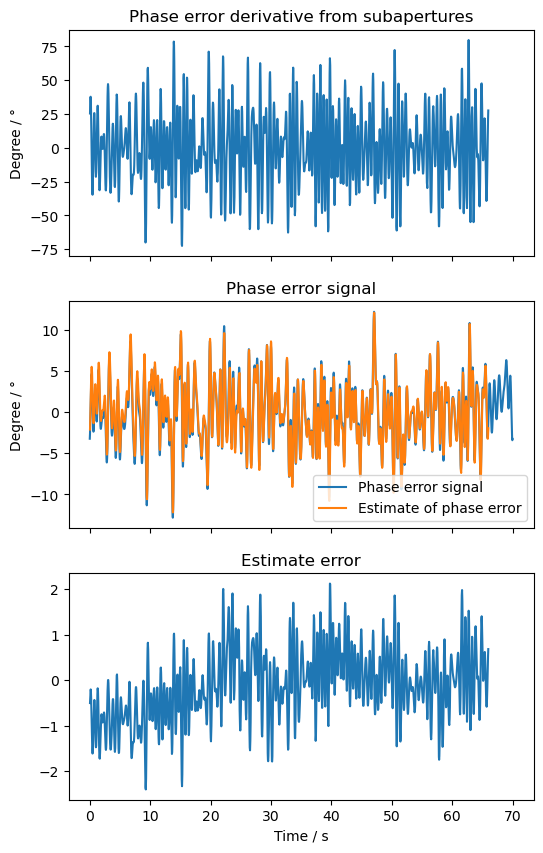

In [57]:
(fig, (ax1, ax2, ax3)) = plt.subplots(3, 1, figsize=(6, 10), sharex=True)
ax1.plot(sensing_times_tiled, phase_error_der)
ax1.set_ylabel("Degree / °")
ax2.set_ylabel("Degree / °")
ax1.set_title("Phase error derivative from subapertures")
ax2.plot(
    time_phase,
    phase_error,
    label="Phase error signal"
)
ax2.set_title("Phase error signal")
ax2.plot(sensing_times_tiled, x_est, label="Estimate of phase error")
ax2.legend()
ax3.plot(sensing_times_tiled, phase_error_tiled - x_est)
ax3.set_title("Estimate error")
ax2.set_ylabel("Degree / °")
ax3.set_xlabel("Time / s")

Text(0.5, 0, 'Time / s')

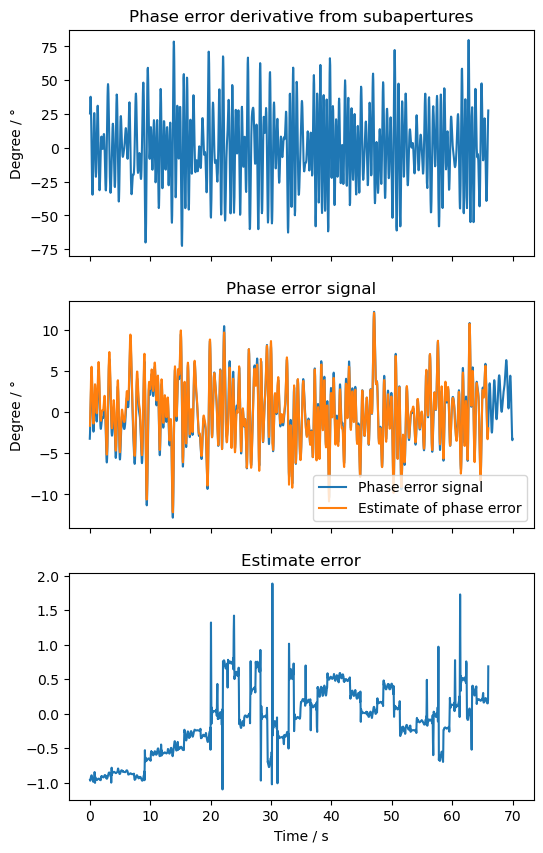

In [58]:
(fig, (ax1, ax2, ax3)) = plt.subplots(3, 1, figsize=(6, 10), sharex=True)
ax1.plot(sensing_times_tiled, phase_error_der)
ax1.set_ylabel("Degree / °")
ax2.set_ylabel("Degree / °")
ax1.set_title("Phase error derivative from subapertures")
ax2.plot(
    time_phase,
    phase_error,
    label="Phase error signal"
)
ax2.set_title("Phase error signal")
ax2.plot(sensing_times_tiled, x_shift, label="Estimate of phase error")
ax2.legend()
ax3.plot(sensing_times_tiled, phase_error_tiled - x_shift)
ax3.set_title("Estimate error")
ax2.set_ylabel("Degree / °")
ax3.set_xlabel("Time / s")

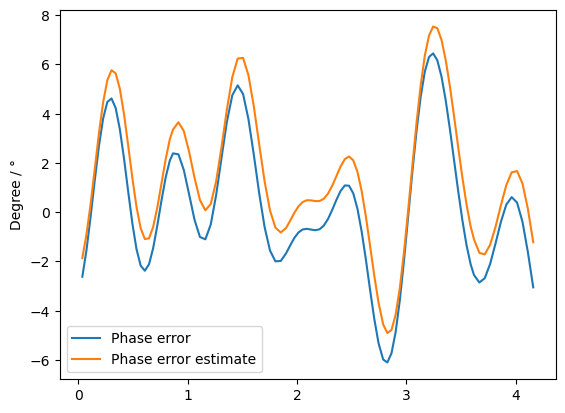

In [59]:
fig, ax = plt.subplots()
ax.plot(sensing_times_tiled[:100], phase_error_tiled[:100], label="Phase error")
ax.set_ylabel("Degree / °")
ax.plot(
    sensing_times_tiled[:100],
    x_est[:100] + np.mean(phase_error_tiled[:100]),
    label="Phase error estimate"
)
ax.legend()

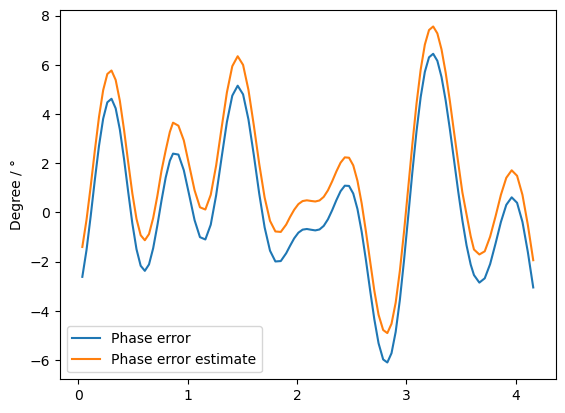

In [60]:
fig, ax = plt.subplots()
ax.plot(sensing_times_tiled[:100], phase_error_tiled[:100], label="Phase error")
ax.set_ylabel("Degree / °")
ax.plot(
    sensing_times_tiled[:100],
    x_shift[:100] + np.mean(phase_error_tiled[:100]),
    label="Phase error estimate"
)
ax.legend()

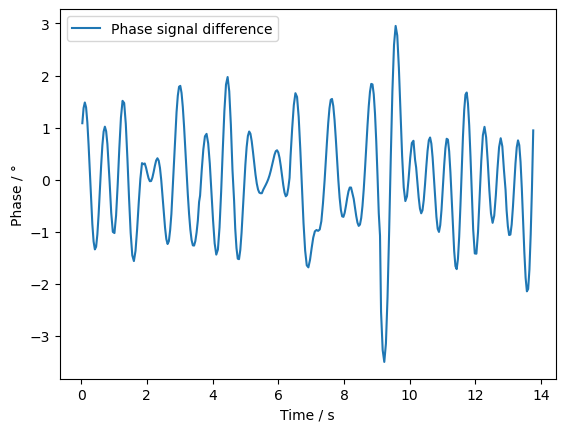

In [61]:
fig, ax = plt.subplots()
#ax.plot(sensing_times_tiled[:330], phase_error_tiled[:330] - x_shift[:330], label="Residual")
ax.set_ylabel("Phase / °")
ax.set_xlabel("Time / s")
ax.plot(sensing_times_tiled[:330], np.diff(phase_error_tiled[:331]), label="Phase signal difference")
ax.legend()

In [62]:
mosaic_iw2_error["line"] = mosaic_iw2_error.line + 7

In [63]:
mosaic_iw3_error["line"] = mosaic_iw3_error.line + 13

In [64]:
mosaic_iw12 = mosaic_iw1_error.isel(
    grg=mosaic_iw1_error.grg < mosaic_iw2_error.grg.isel(grg=0)
).combine_first(mosaic_iw2_error)
mosaic_iw123 = mosaic_iw12.isel(grg= mosaic_iw12.grg < mosaic_iw3_error.grg.isel(grg=0)).combine_first(mosaic_iw3_error)

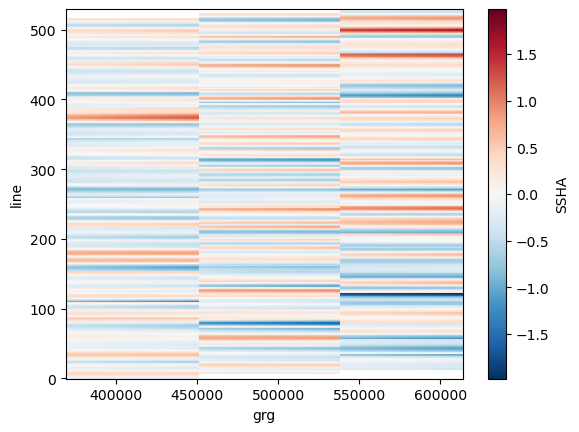

In [65]:
mosaic_iw123.plot()

In [66]:
height_error_clock_iw1.isel(line=slice(20,26)).az

<xarray.DataArray 'az' (line: 6)>
array([20000., 21000., 20000., 21000., 22000., 23000.])
Coordinates:
    az            (line) float64 2e+04 2.1e+04 2e+04 2.1e+04 2.2e+04 2.3e+04
    azimuth_time  (line) float64 2.79 2.93 2.79 2.93 3.07 3.209
  * line          (line) float64 20.0 21.0 22.0 23.0 24.0 25.0

In [67]:
_, time_iw1_ind, _ = np.intersect1d(
    sensing_times_tiled,
    np.concatenate(sensing_times_iw1),
    assume_unique=True,
    return_indices=True,
)
_, time_iw2_ind, _ = np.intersect1d(
    sensing_times_tiled,
    np.concatenate(sensing_times_iw2),
    assume_unique=True,
    return_indices=True,
)
_, time_iw3_ind, _ = np.intersect1d(
    sensing_times_tiled,
    np.concatenate(sensing_times_iw3),
    assume_unique=True,
    return_indices=True,
)

In [68]:
heigth_residual = (
    np.deg2rad(phase_error_iw1 - x_shift[time_iw1_ind])[:, np.newaxis]
    / (2 * np.pi)
    * h_amb_roi.sel(grg=mosaic_iw1.grg, az=mosaic_iw1.az)
)
height_corrected_iw1 = mosaic_iw1.SSHA + heigth_residual

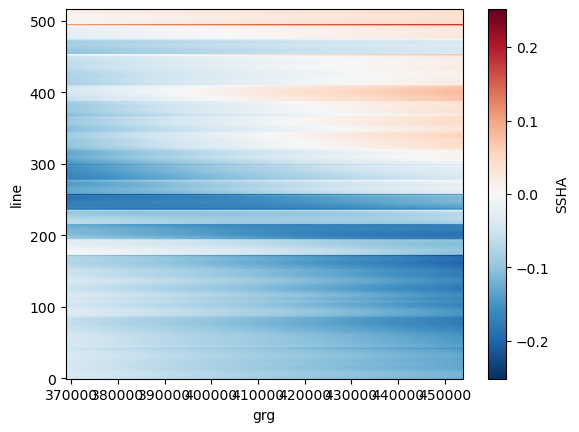

In [69]:
height_corrected_iw1.plot()

In [70]:
heigth_residual = (
    np.deg2rad(phase_error_iw2 - x_shift[time_iw2_ind])[:, np.newaxis]
    / (2 * np.pi)
    * h_amb_roi.sel(grg=mosaic_iw2.grg, az=mosaic_iw2.az)
)
height_corrected_iw2 = mosaic_iw2.SSHA + heigth_residual

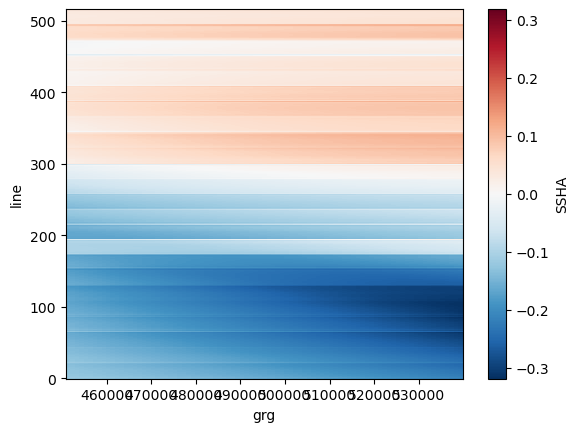

In [71]:
height_corrected_iw2.plot()

In [72]:
heigth_residual = (
    np.deg2rad(phase_error_iw3 - x_shift[time_iw3_ind])[:, np.newaxis]
    / (2 * np.pi)
    * h_amb_roi.sel(grg=mosaic_iw3.grg, az=mosaic_iw3.az)
)
height_corrected_iw3 = mosaic_iw3.SSHA + heigth_residual

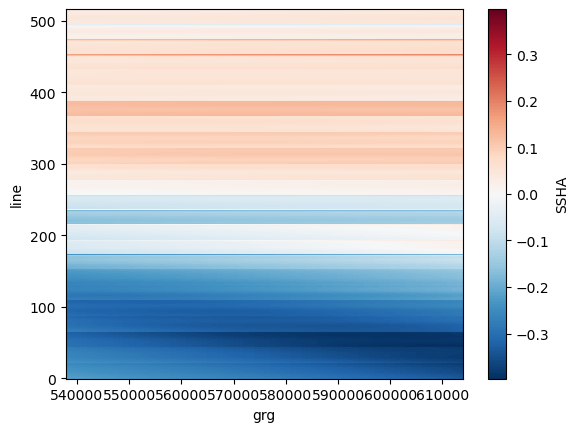

In [73]:
height_corrected_iw3.plot()

In [74]:
height_corrected_iw2["line"] = height_corrected_iw2.line + 7
height_corrected_iw3["line"] = height_corrected_iw3.line + 13

In [75]:
height_corrected_iw12 = height_corrected_iw1.isel(
    grg=height_corrected_iw1.grg < height_corrected_iw2.grg.isel(grg=0)
).combine_first(height_corrected_iw2)
height_corrected_iw123 = height_corrected_iw12.isel(
    grg=height_corrected_iw12.grg < height_corrected_iw3.grg.isel(grg=0)
).combine_first(height_corrected_iw3)

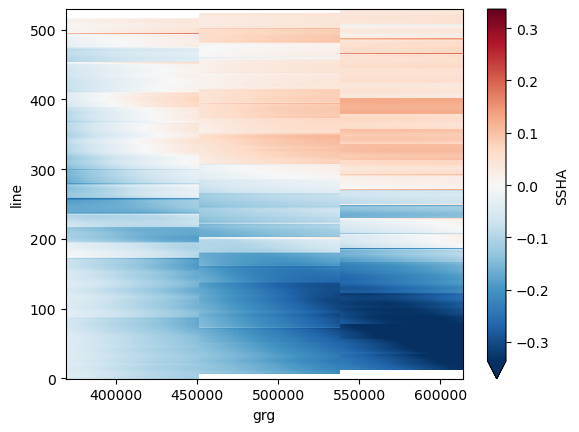

In [76]:
height_corrected_iw123.plot(robust=True)

Text(0, 0.5, 'Line')

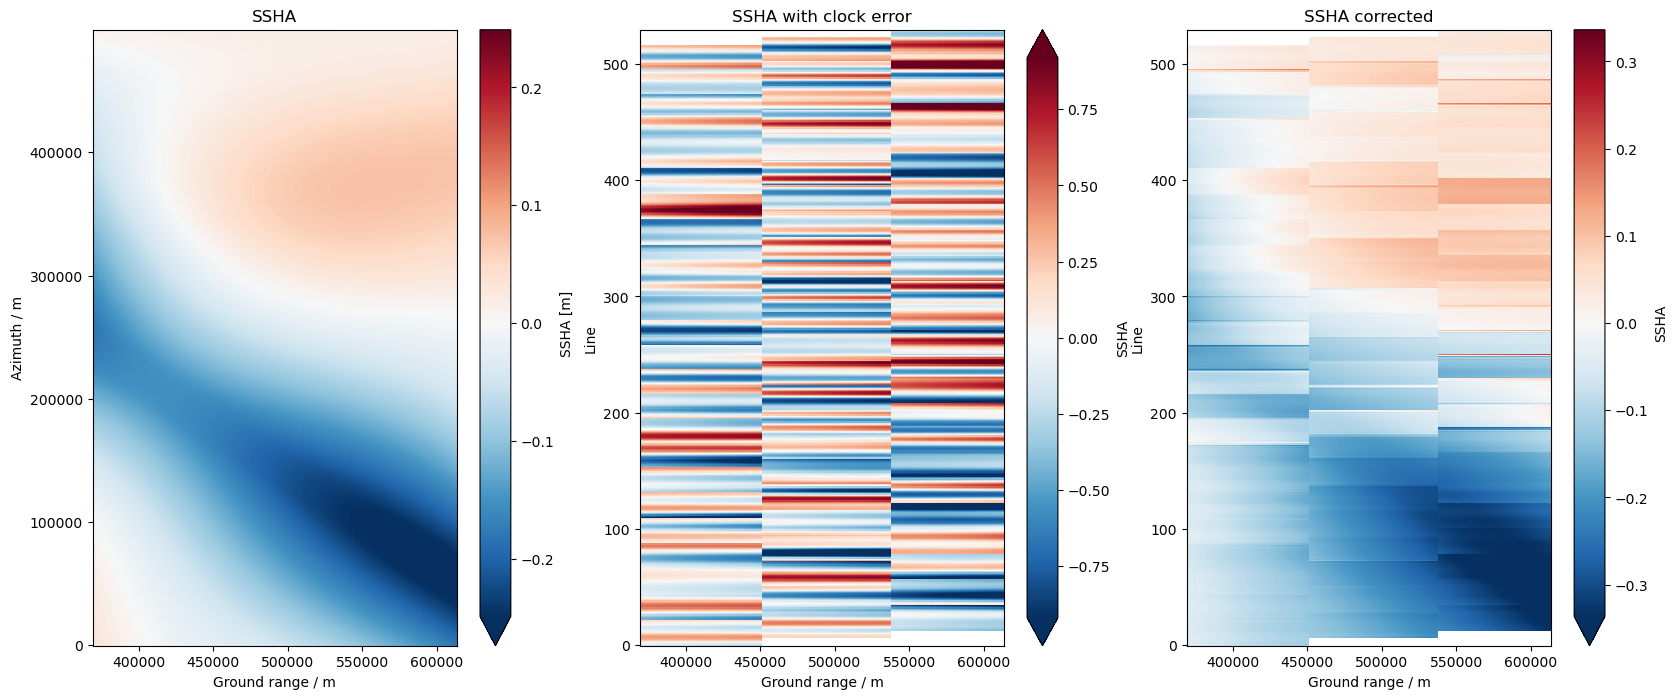

In [77]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 8))
tc_ds.SSHA.plot(ax=ax1, robust=True)
ax1.set_title("SSHA")
ax1.set_xlabel("Ground range / m")
ax1.set_ylabel("Azimuth / m")
mosaic_iw123.plot(ax=ax2, robust=True)
ax2.set_title("SSHA with clock error")
ax2.set_xlabel("Ground range / m")
ax2.set_ylabel("Line")
height_corrected_iw123.plot(ax=ax3, robust=True)
ax3.set_title("SSHA corrected")
ax3.set_xlabel("Ground range / m")
ax3.set_ylabel("Line")

In [78]:
height_corrected_iw1 = height_corrected_iw1.swap_dims({"line": "az"})

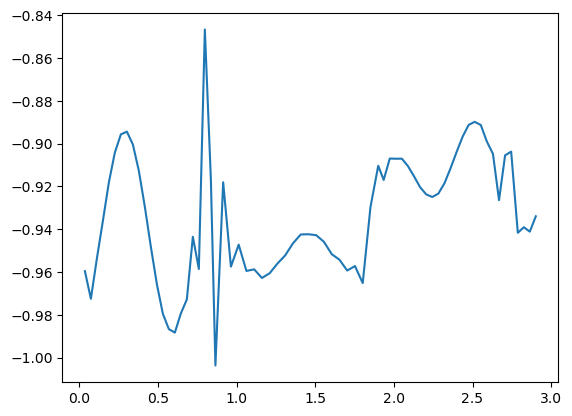

In [78]:
plt.plot(sensing_times_tiled[:70], phase_error_tiled[:70] - x_shift[:70])

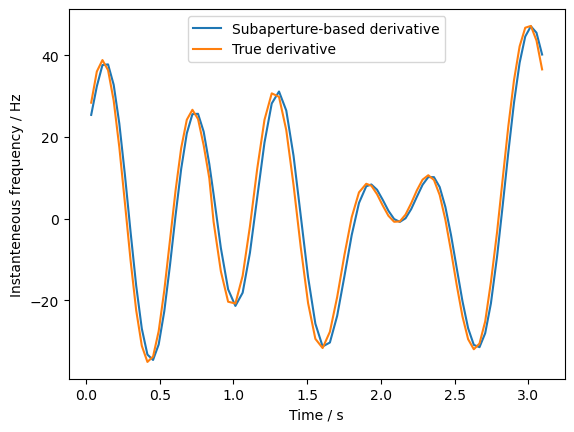

In [79]:
fig, ax = plt.subplots()
ax.plot(sensing_times_tiled[:75], phase_error_der[:75], label="Subaperture-based derivative")
ax.plot(sensing_times_tiled[:75], np.diff(phase_error_tiled[:76]) / np.diff(sensing_times_tiled[:76]), label="True derivative")
ax.set_xlabel("Time / s")
ax.set_ylabel("Instanteneous frequency / Hz")
ax.legend()

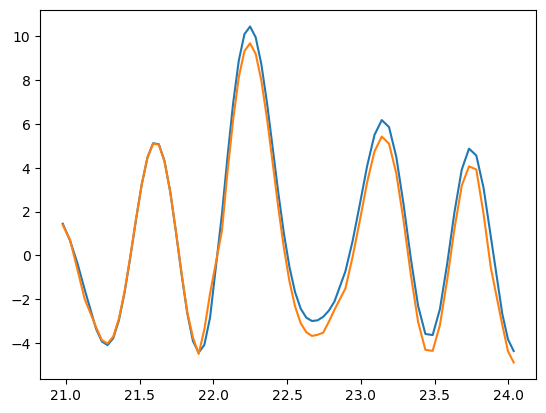

In [80]:
plt.plot(sensing_times_tiled[500:570], phase_error_tiled[500:570])
plt.plot(sensing_times_tiled[500:570], x_shift[500:570])

In [81]:
sensing_times_iw1_tiled = np.concatenate(sensing_times_iw1)

In [82]:
x_iw1 = np.zeros_like(x_shift)

In [83]:
_, iw1_ind, _ = np.intersect1d(sensing_times_tiled, sensing_times_iw1_tiled, return_indices=True)

In [141]:
x_iw1[b_ind]

array([ 8.97576417,  9.92331731, 11.66002628, 13.67516848, 15.7468735 ,
       17.53394962, 18.82350772, 19.48483728, 19.52264149, 19.05456888,
       18.28881691, 17.47541546, 16.85474041, 16.60596612, 16.81222162,
       17.43873251, 18.35108978, 19.31812387, 20.11924409, 20.4535401 ,
       20.35666305])

In [142]:
x_shift[b_ind]

array([ 8.97576417,  9.92331731, 11.66002628, 13.67516848, 15.7468735 ,
       17.53394962, 18.82350772, 19.48483728, 19.52264149, 19.05456888,
       18.28881691, 17.47541546, 16.85474041, 16.60596612, 16.81222162,
       17.43873251, 18.35108978, 19.31812387, 20.11924409, 20.4535401 ,
       20.35666305])

In [138]:
der * (sensing_times_iw1[i][-1] - sensing_times_iw1[i][0])

array([-15.34164258])

In [662]:
height_corrected_iw1_t = height_corrected_iw1.copy(deep=True)

In [663]:
#height_corrected_iw1_t = height_corrected_iw1_t.to_dataset(name="SSHA")
height_corrected_iw1_t = height_corrected_iw1_t.assign_attrs({"subswath_number": 1})

In [664]:
line_burst_beg = 0
correction_factor = []
burst_starts = [0]
for i, t in enumerate(sensing_times_iw1[:-1]):
    len_t = len(t)
    len_t_next = len(sensing_times_iw1[1+1])
    n_overlap_samples = int(np.sum(height_corrected_iw1_t.isel(line=slice(line_burst_beg, line_burst_beg + len_t)).az >= height_corrected_iw1_t.isel(line=line_burst_beg + len_t).az))
    current_b_edges = height_corrected_iw1_t.isel(line=slice(line_burst_beg + len_t - n_overlap_samples, line_burst_beg + len_t)).values
    next_b_edges = height_corrected_iw1_t.isel(line=slice(line_burst_beg + len_t, line_burst_beg + len_t + n_overlap_samples)).values
    factor = current_b_edges - next_b_edges
    if factor.ndim > 1:
        factor = np.min(factor, axis=0)
    height_corrected_iw1_t[line_burst_beg + len_t: line_burst_beg + len_t + len_t_next] += factor
    correction_factor.append(factor)
    line_burst_beg += len_t
    burst_starts.append(line_burst_beg)

In [623]:
# line_burst_beg = 0
# correction_factor = []
# for i, t in enumerate(sensing_times_iw1[:-1]):
#     len_t = len(t)
#     len_t_next = len(sensing_times_iw1[1+1])
#     n_overlap_samples = int(np.sum(height_corrected_iw1_t.isel(line=slice(line_burst_beg, line_burst_beg + len_t)).az >= height_corrected_iw1_t.isel(line=line_burst_beg + len_t).az))
#     current_b_edges = height_corrected_iw1_t.isel(line=slice(line_burst_beg + len_t - n_overlap_samples, line_burst_beg + len_t)).values
#     next_b_edges = height_corrected_iw1_t.isel(line=slice(line_burst_beg + len_t, line_burst_beg + len_t + n_overlap_samples)).values
#     current_b_mean = height_corrected_iw1_t.isel(line=slice(line_burst_beg+2, line_burst_beg + len_t - n_overlap_samples)).mean()
#     next_b_mean = height_corrected_iw1_t.isel(line=slice(line_burst_beg + len_t + n_overlap_samples + 1, line_burst_beg + int(1.8*len_t) + n_overlap_samples)).mean()
#     outliers_current_b = (current_b_edges - current_b_mean.values) > 2*np.std(height_corrected_iw1_t.isel(line=slice(line_burst_beg, line_burst_beg + len_t - n_overlap_samples))).values
#     if np.any(outliers_current_b):
#         # current_b_edges = current_b_mean.to_numpy()
#         current_b_edges = height_corrected_iw1_t.isel(line=slice(line_burst_beg+15, line_burst_beg + len_t - n_overlap_samples)).mean(dim="line").to_numpy()
#     outliers_next_b = (next_b_edges - next_b_mean.values) > 2*np.std(height_corrected_iw1_t.isel(line=slice(line_burst_beg + len_t + n_overlap_samples, line_burst_beg + int(1.8*len_t) + n_overlap_samples))).values
#     if np.any(outliers_next_b):
#         #next_b_edges = next_b_mean.to_numpy()
#         next_b_edges = height_corrected_iw1_t.isel(line=slice(line_burst_beg + len_t + n_overlap_samples + 1, line_burst_beg + len_t + n_overlap_samples + 6)).mean(dim="line").to_numpy()
#     factor = current_b_edges - next_b_edges
#     if factor.ndim > 1:
#         factor = np.max(factor, axis=0)
#     height_corrected_iw1_t[line_burst_beg + len_t: line_burst_beg + len_t + len_t_next] += factor
#     correction_factor.append(factor)
#     line_burst_beg += len_t

In [632]:
line_burst_beg = len(sensing_times_iw1[0])
for i, t in enumerate(sensing_times_iw1[1:]):
    len_t = len(t)
    height_corrected_iw1_t[line_burst_beg: line_burst_beg + len_t] += correction_factor[i]
    line_burst_beg += len_t

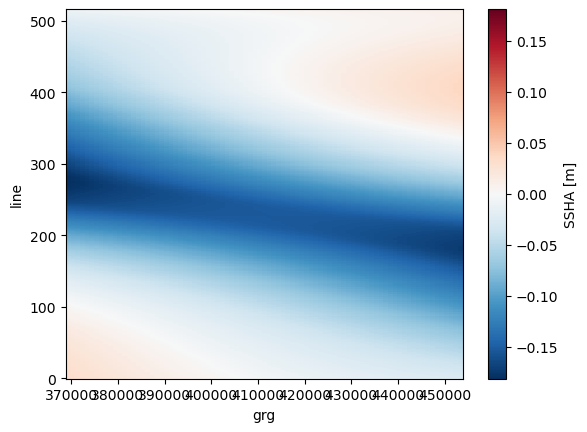

In [633]:
mosaic_iw1.SSHA.plot()

In [640]:
height_corrected_iw1_t = height_corrected_iw1_t.swap_dims({"line": "az"})

In [641]:
height_corrected_iw1_t_no_overlap = height_corrected_iw1_t.drop_duplicates("az", keep="last")

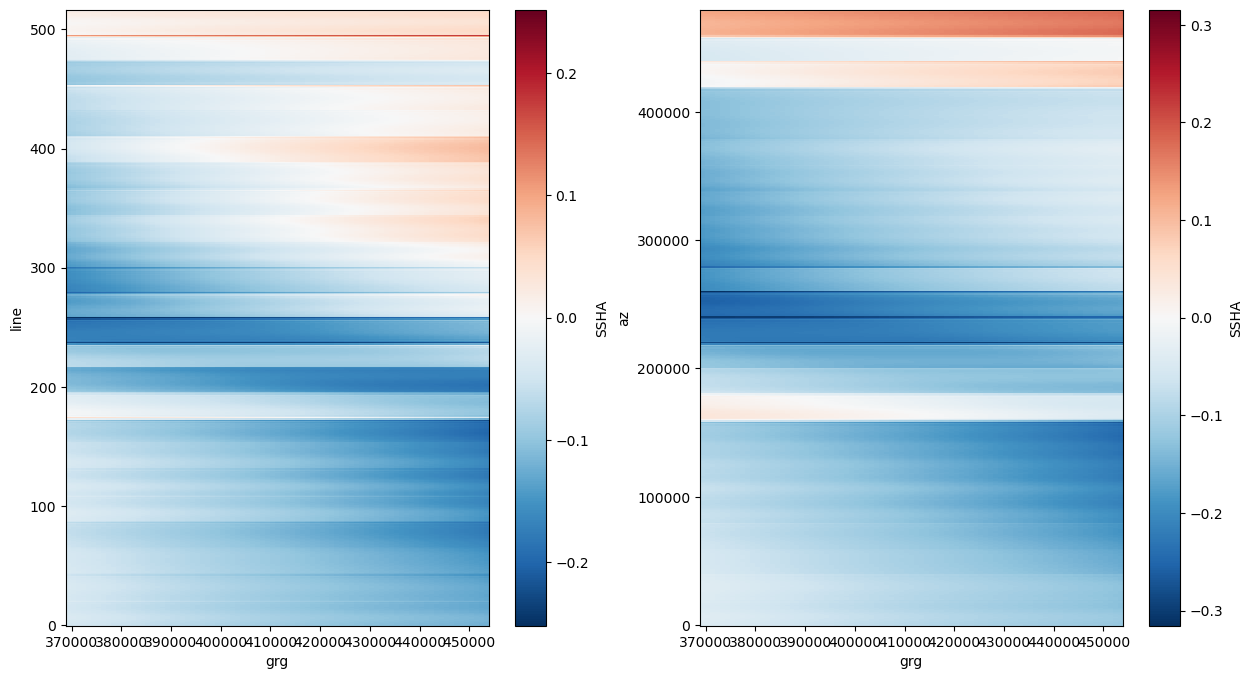

In [642]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))
height_corrected_iw1.plot(ax=ax1)
height_corrected_iw1_t_no_overlap.plot(ax=ax2)

In [651]:
burst_lens_iw1 = [len(t) for t in sensing_times_iw1]
burst_inds_iw1 = np.cumsum(burst_lens_iw1)

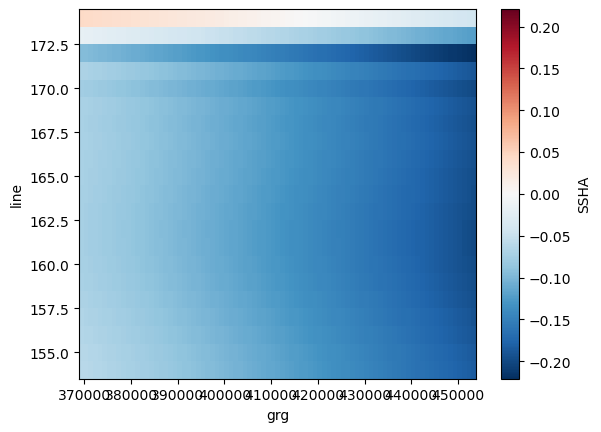

In [654]:
height_corrected_iw1.isel(line=slice(burst_inds_iw1[6], burst_inds_iw1[7])).plot()

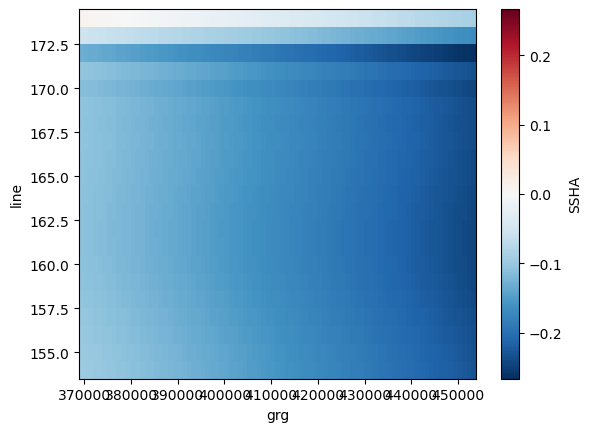

In [669]:
height_corrected_iw1_t.isel(line=slice(burst_inds_iw1[6], burst_inds_iw1[7])).plot()

In [657]:
height_corrected_iw1.isel(line=slice(burst_inds_iw1[6], burst_inds_iw1[7])).az

<xarray.DataArray 'az' (line: 21)>
array([140000., 141000., 142000., 143000., 144000., 145000., 146000.,
       147000., 148000., 149000., 150000., 151000., 152000., 153000.,
       154000., 155000., 156000., 157000., 158000., 159000., 160000.])
Coordinates:
    az            (line) float64 1.4e+05 1.41e+05 1.42e+05 ... 1.59e+05 1.6e+05
    azimuth_time  (line) float64 19.53 19.67 19.81 19.95 ... 22.04 22.18 22.32
  * line          (line) float64 154.0 155.0 156.0 157.0 ... 172.0 173.0 174.0

In [660]:
height_corrected_iw1.isel(line=slice(burst_inds_iw1[6], burst_inds_iw1[9])).az

<xarray.DataArray 'az' (line: 63)>
array([140000., 141000., 142000., 143000., 144000., 145000., 146000.,
       147000., 148000., 149000., 150000., 151000., 152000., 153000.,
       154000., 155000., 156000., 157000., 158000., 159000., 160000.,
       160000., 161000., 162000., 163000., 164000., 165000., 166000.,
       167000., 168000., 169000., 170000., 171000., 172000., 173000.,
       174000., 175000., 176000., 177000., 178000., 179000., 180000.,
       180000., 181000., 182000., 183000., 184000., 185000., 186000.,
       187000., 188000., 189000., 190000., 191000., 192000., 193000.,
       194000., 195000., 196000., 197000., 198000., 199000., 200000.])
Coordinates:
    az            (line) float64 1.4e+05 1.41e+05 1.42e+05 ... 1.99e+05 2e+05
    azimuth_time  (line) float64 19.53 19.67 19.81 19.95 ... 27.63 27.77 27.9
  * line          (line) float64 154.0 155.0 156.0 157.0 ... 214.0 215.0 216.0

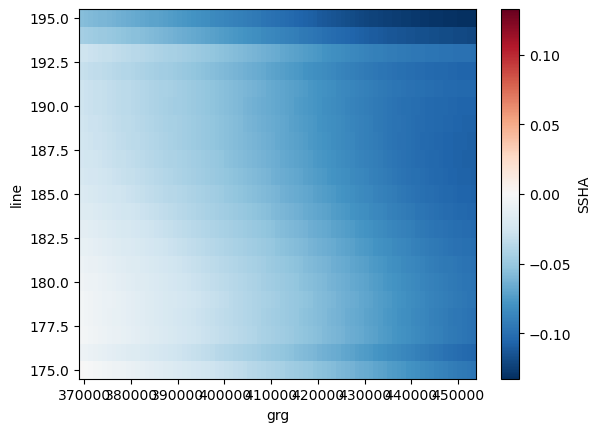

In [668]:
height_corrected_iw1.isel(line=slice(burst_inds_iw1[7], burst_inds_iw1[8])).plot()

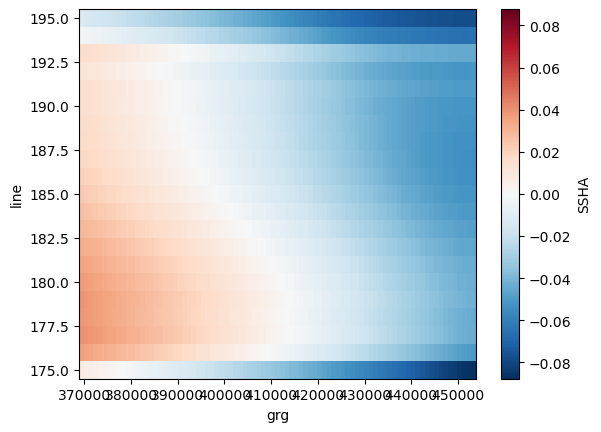

In [670]:
height_corrected_iw1_t.isel(line=slice(burst_inds_iw1[7], burst_inds_iw1[8])).plot()

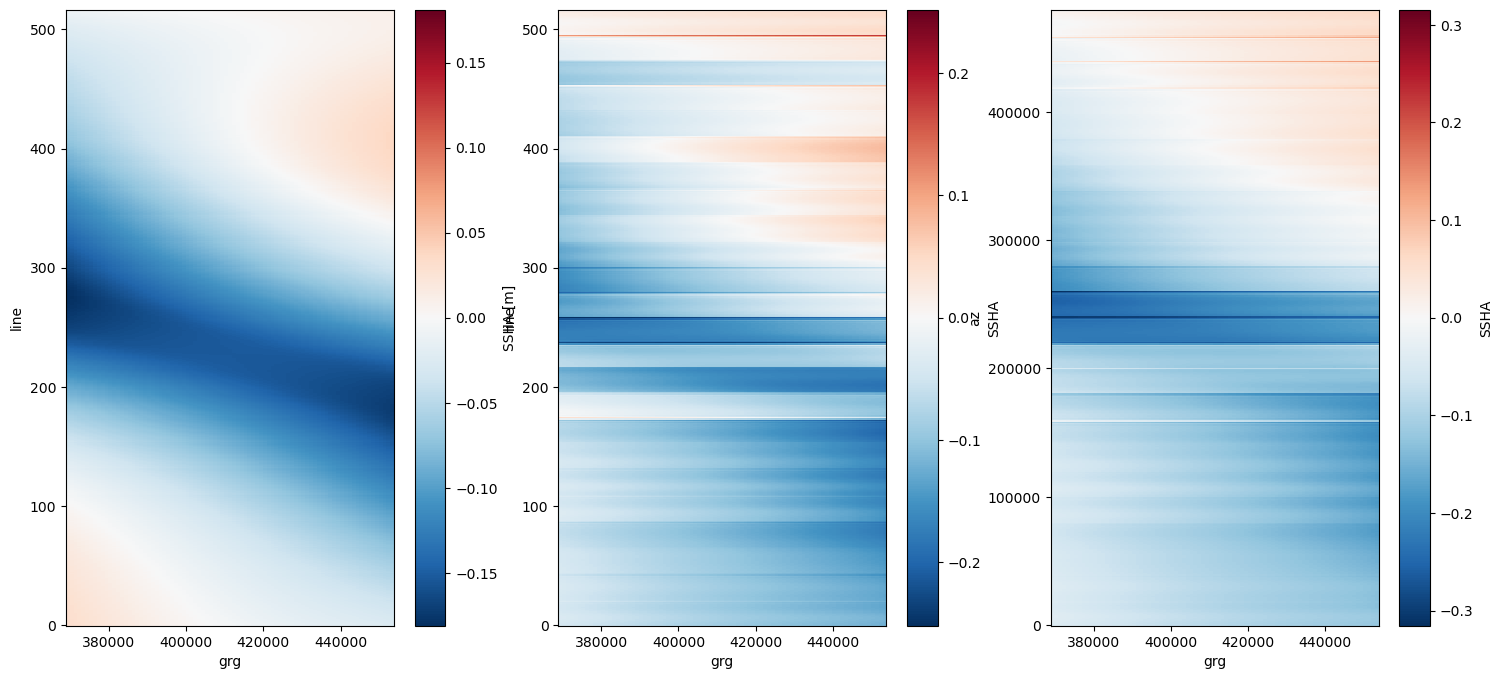

In [628]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 8))
mosaic_iw1.SSHA.plot(ax=ax1)
height_corrected_iw1.plot(ax=ax2)
height_corrected_iw1_t_no_overlap.plot(ax=ax3)

In [687]:
phase_error_int = sinc_interpolation(phase_error, time_phase, sensing_times_tiled)

Text(0.5, 0, 'Time / s')

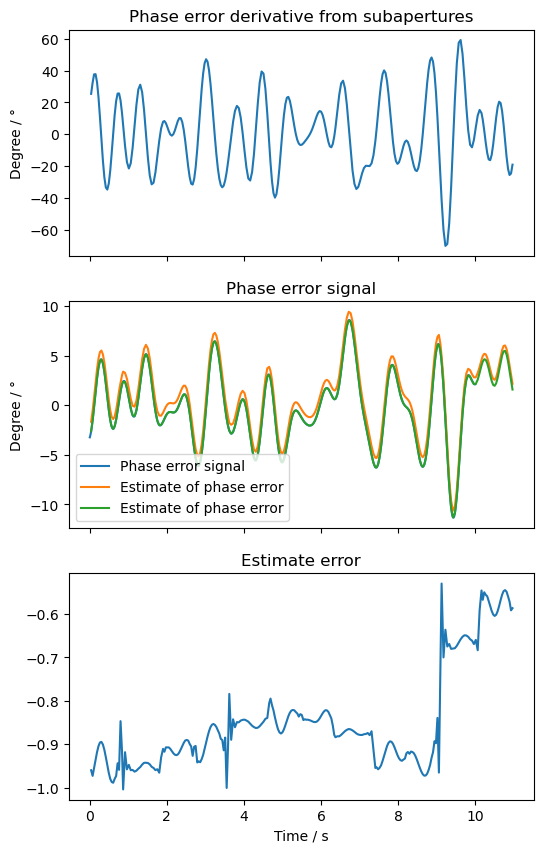

In [698]:
(fig, (ax1, ax2, ax3)) = plt.subplots(3, 1, figsize=(6, 10), sharex=True)
ax1.plot(sensing_times_tiled[:263], phase_error_der[:263])
ax1.set_ylabel("Degree / °")
ax2.set_ylabel("Degree / °")
ax1.set_title("Phase error derivative from subapertures")
ax2.plot(
    time_phase[:10000],
    phase_error[:10000],
    label="Phase error signal"
)
ax2.set_title("Phase error signal")
ax2.plot(sensing_times_tiled[:263], x_shift[:263], label="Estimate of phase error")
ax2.plot(sensing_times_tiled[:263], phase_error_tiled[:263], label="Estimate of phase error")
ax2.legend()
ax3.plot(sensing_times_tiled[:263], (phase_error_tiled - x_shift)[:263])
ax3.set_title("Estimate error")
ax2.set_ylabel("Degree / °")
ax3.set_xlabel("Time / s")

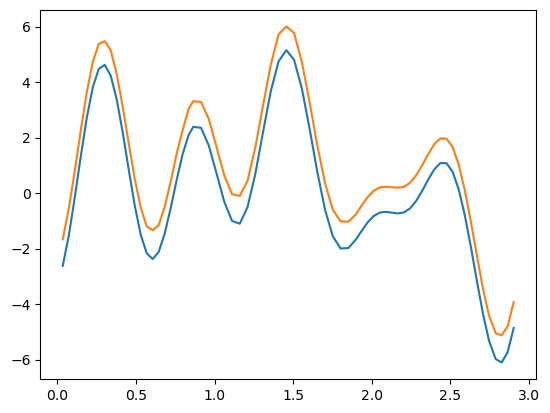

In [715]:
plt.plot(sensing_times_tiled[:70], phase_error_tiled[:70])
plt.plot(sensing_times_tiled[:70], x_shift[:70])

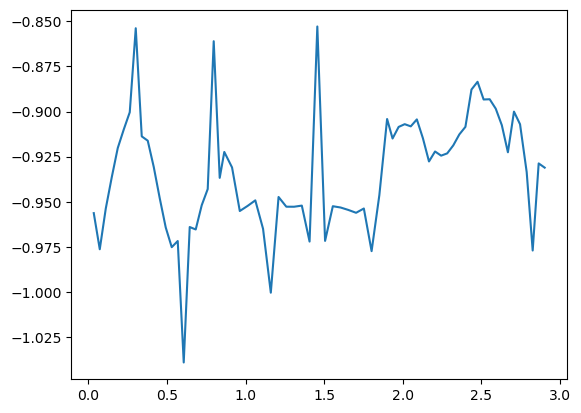

In [716]:
plt.plot(sensing_times_tiled[:70], phase_error_tiled[:70]-x_shift[:70])